In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#데이터 열기

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Kaggle/archive/Reviews.csv')
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
print("전체 학습 데이터 개수: {}".format(len(data)))

전체 학습 데이터 개수: 568454


In [ ]:
text_length=data['Text'].apply(len)
print('리뷰 길이 최댓값: {}'.format(np.max(text_length)))
print('리뷰 길이 최솟값: {}'.format(np.min(text_length)))
print('리뷰 길이 평균값: {:.2f}'.format(np.mean(text_length)))
print('리뷰 길이 표준편차: {:.2f}'.format(np.std(text_length)))
print('리뷰 길이 중간값: {}'.format(np.median(text_length)))
print('리뷰 길이 제1사분위: {}'.format(np.percentile(text_length, 25)))
print('리뷰 길이 제3사분위: {}'.format(np.percentile(text_length, 75)))

리뷰 길이 최댓값: 21409
리뷰 길이 최솟값: 12
리뷰 길이 평균값: 436.22
리뷰 길이 표준편차: 445.34
리뷰 길이 중간값: 302.0
리뷰 길이 제1사분위: 179.0
리뷰 길이 제3사분위: 527.0


#중복 제거

In [ ]:
sorted_data = data.sort_values('ProductId',axis=0,ascending=True,kind='quicksort',na_position='last')
non_redundant = sorted_data.drop_duplicates(subset={"UserId","Time","ProfileName","Text"},keep='first')
non_redundant = non_redundant[non_redundant['HelpfulnessNumerator']<=non_redundant['HelpfulnessDenominator']]

In [ ]:
print(non_redundant.shape[1])

10


In [ ]:
print("Percentage of data remained = ",(non_redundant["Id"].size*1.0/data["Id"].size*1.0)*100)

Percentage of data remained =  69.29865917031105


In [ ]:
print(non_redundant.isna().any())
non_redundant.dropna(axis=0,inplace=True)

Id                        False
ProductId                 False
UserId                    False
ProfileName                True
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                    True
Text                      False
dtype: bool


#데이터 전처리

html 태그 제거

In [ ]:
import re
print(non_redundant['Text'].values[0])

print("\n",'='*50,'\n')
print(re.sub(r"http\S+","",non_redundant['Text'].values[0]))

In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.


In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of 

In [ ]:
from bs4 import BeautifulSoup


print(non_redundant['Text'].values[0])
print("\n",'='*50,'\n')

print(BeautifulSoup(non_redundant['Text'].values[0]))
print("\n",'='*50,'\n')

text = BeautifulSoup(non_redundant['Text'].values[0])
text = text.get_text() # Extracting text from the html object.
print(text)

In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.


<html><body><p>In June<br/>I saw a charming group<br/>of roses all begin<br/>to droop<br/>I pepped them up<br/>with chicken soup!<br/>Sprinkle once<br/>sprinkle twice<br/>sprinkle chicken soup<br/>with rice<br/><br/>This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some

특수문자와 구두점 제거

In [ ]:
print(re.sub('[^A-Za-z0-9]+',' ',non_redundant['Text'].values[0]))

In June br I saw a charming group br of roses all begin br to droop br I pepped them up br with chicken soup br Sprinkle once br sprinkle twice br sprinkle chicken soup br with rice br br This is a great book to teach children the months of the year The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read This isn t nearly as good as some of Sendak s other books like Where the Wild Things are or Pierre The Boy Who Didn t Care but it still carries his unique brand of charm 


In [ ]:
print(re.sub('\S*\d\S*','',non_redundant['Text'].values[0]))

In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.


줄임 문자 변경

In [ ]:
def decontraction(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

print(non_redundant['Text'].values[11])
# As we can there is "'t" in our sentence. we need to replace all these words to their original words.
print("\n",'='*50,'\n')

# For this to fully work first we need to convert the sentence to lower case.
# Anyways we can are going to use it here as this is just an example.
print(decontraction(non_redundant['Text'].values[11]))

One of my earliest memories is of this book.  My mother, who read to us constantly, read this one to us, and we quoted it non-stop.  In fact, that was a typical sort of soup we would beg for at the grocery because of this book!<br /><br />Since then, I have used the book in every class/teaching situation I have been in.  I have never met a child who did not LOVE it, and ask to be read it again and again.  It sure beats all those stupid songs you sing in preschool about the months of the year! :)  Even if you are not a Maurice Sendak fan, you will enjoy this one, because it is so original and poetic.


One of my earliest memories is of this book.  My mother, who read to us constantly, read this one to us, and we quoted it non-stop.  In fact, that was a typical sort of soup we would beg for at the grocery because of this book!<br /><br />Since then, I have used the book in every class/teaching situation I have been in.  I have never met a child who did not LOVE it, and ask to be read it 

모두 소문자로

In [ ]:
def lower_case(sentence):
    sentence = ' '.join(e.lower() for e in sentence.split())
    return sentence

print(lower_case(non_redundant['Text'].values[900]))

this is a wonderful color assortment for any decorator. the colors blend in well and can be easily combined to create more variations.


불용어 제거

In [ ]:
import nltk
from nltk.corpus import stopwords
stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])
# Creating sets of stop keywords
print(stopwords)

def rm_stop_words(sentence):
    sentence = ' '.join(e for e in sentence.split() if e not in stopwords)
    return sentence

print(non_redundant['Text'].values[900])
print("\n",'='*50,'\n')
print(rm_stop_words(non_redundant['Text'].values[900]))

{'which', 've', 'before', 'or', 'with', "mustn't", 'who', "she's", 'each', 'were', 'themselves', 'o', 'have', 'an', 'this', 'ours', "it's", 'where', 'their', 's', 'other', 'some', 'few', 'did', 'her', 'br', 'our', 'me', 'be', "that'll", 'aren', "shouldn't", 'how', 're', 'once', 'can', 'between', "you've", 'he', 'through', 'to', 'here', 'am', "you'd", 'will', "wasn't", 'we', 'out', 'these', 'doesn', 'during', 'that', 'does', 'as', 'don', 'what', 'yours', 'won', 'off', 'was', 'having', 'haven', 'because', "isn't", 'if', 'doing', 'at', 'when', 'by', 'so', "weren't", "aren't", 'again', 'being', 'over', 'i', 'm', 'on', 'them', 'had', 'shan', "shan't", 't', 'y', 'whom', 'of', "should've", 'but', 'his', 'up', 'from', 'most', 'my', 'needn', 'are', 'just', 'it', 'above', 'under', 'shouldn', 'they', 'a', 'mightn', "wouldn't", "hasn't", "you'll", 'your', 'didn', 'own', 'do', 'there', 'weren', 'same', 'ma', 'in', 'theirs', 'the', 'than', 'll', 'isn', 'very', "haven't", 'yourself', 'against', 'whil

stemming (영어만 뽑아내기)

In [ ]:
from nltk.stem import SnowballStemmer
print(" ".join(SnowballStemmer.languages))

arabic danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


In [ ]:
stemmer = SnowballStemmer('english') # Selecting english language for stemming
stemmer.stem('manly')

'man'

최종

In [ ]:
from tqdm import tqdm
import pdb
index,reviews = [],[]
preprocessed_review = []
for review in tqdm(non_redundant['Text'].values):
    review = re.sub(r'http\S+','',review)
    review = BeautifulSoup(review).get_text()
    review = re.sub('[^A-Za-z0-9]+',' ',review)  
    review = re.sub('\S*\d\S*','',review)
    review = ' '.join(e.lower() for e in review.split() if e.lower() not in stopwords) #Removing Stop words and loweri casing letter at same time.
    preprocessed_review.append(decontraction(review))

100%|██████████| 393917/393917 [02:39<00:00, 2471.06it/s]


In [ ]:
print(preprocessed_review[1500])
print('\n',len(preprocessed_review))

cat loves bubbles say want bubbles comes running wherever may hiding meows pounces bubbles giving rating though smell horrible drip anything white turn green easily cleaned water sponge

 393917


#Pre-trained Embedding

사전훈련된 glove 다운로드

In [ ]:
import numpy as np
import gensim
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

In [ ]:
urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zf=zipfile.ZipFile("glove.6B.zip")
zf.extractall()
zf.close()

In [ ]:
glove_dict=dict()
f=open('glove.6B.100d.txt', encoding='utf8')
for line in f:
  word_vector=line.split()
  word=word_vector[0]
  word_vector_arr=np.asarray(word_vector[1:], dtype='float32')
  glove_dict[word]=word_vector_arr
f.close()

In [ ]:
glove_dict['cat']

array([ 0.23088  ,  0.28283  ,  0.6318   , -0.59411  , -0.58599  ,
        0.63255  ,  0.24402  , -0.14108  ,  0.060815 , -0.7898   ,
       -0.29102  ,  0.14287  ,  0.72274  ,  0.20428  ,  0.1407   ,
        0.98757  ,  0.52533  ,  0.097456 ,  0.8822   ,  0.51221  ,
        0.40204  ,  0.21169  , -0.013109 , -0.71616  ,  0.55387  ,
        1.1452   , -0.88044  , -0.50216  , -0.22814  ,  0.023885 ,
        0.1072   ,  0.083739 ,  0.55015  ,  0.58479  ,  0.75816  ,
        0.45706  , -0.28001  ,  0.25225  ,  0.68965  , -0.60972  ,
        0.19578  ,  0.044209 , -0.31136  , -0.68826  , -0.22721  ,
        0.46185  , -0.77162  ,  0.10208  ,  0.55636  ,  0.067417 ,
       -0.57207  ,  0.23735  ,  0.4717   ,  0.82765  , -0.29263  ,
       -1.3422   , -0.099277 ,  0.28139  ,  0.41604  ,  0.10583  ,
        0.62203  ,  0.89496  , -0.23446  ,  0.51349  ,  0.99379  ,
        1.1846   , -0.16364  ,  0.20653  ,  0.73854  ,  0.24059  ,
       -0.96473  ,  0.13481  , -0.0072484,  0.33016  , -0.1236

사전훈련된 word2vec 다운로드

In [ ]:
urlretrieve('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', 
            filename='GoogleNews-vectors.negative300.bin.gz')
word2vec_model=gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
word2vec_model['cat']

#TextRank

In [ ]:
import pandas as pd
input=pd.read_csv('/content/drive/MyDrive/Kaggle/archive/Reviews.csv')
dp=[]
for i in range(100):
  dp.append(input.iloc[i])
dp=pd.DataFrame(dp)
dp.to_csv('/content/drive/MyDrive/Kaggle/archive/Reviews_edit2.csv')

In [ ]:
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/Kaggle/archive/Reviews_edit2.csv')
data.head()

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
from nltk import tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from urllib.request import urlretrieve
import zipfile
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words=stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def tokenization(sentence):
  return WordPunctTokenizer().tokenize(sentence)

def preprocess_sentence(sentence):
  sentence=re.sub('[^A-Za-z\s]', ' ', sentence).lower()
  return sentence

def preprocess_sentences(sentences):
  return [preprocess_sentence(sentence) for sentence in sentences]

In [ ]:
preprocess_sentence(data['Text'][0])

'i have bought several of the vitality canned dog food products and have found them all to be of good quality  the product looks more like a stew than a processed meat and it smells better  my labrador is finicky and she appreciates this product better than  most '

In [ ]:
data['Text'][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [ ]:
data['tokenize_Text'][0]

['i',
 'have',
 'bought',
 'several',
 'of',
 'the',
 'vitality',
 'canned',
 'dog',
 'food',
 'products',
 'and',
 'have',
 'found',
 'them',
 'all',
 'to',
 'be',
 'of',
 'good',
 'quality',
 'the',
 'product',
 'looks',
 'more',
 'like',
 'a',
 'stew',
 'than',
 'a',
 'processed',
 'meat',
 'and',
 'it',
 'smells',
 'better',
 'my',
 'labrador',
 'is',
 'finicky',
 'and',
 'she',
 'appreciates',
 'this',
 'product',
 'better',
 'than',
 'most']

In [ ]:
data['tokenize_Text']=data['Text'].apply(preprocess_sentence)
data['tokenize_Text']=data['tokenize_Text'].apply(tokenization)
data

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,tokenize_Text,sentenceEmbedding,simMatrix,summary2
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,"{0: 0.001173708022706181, 1: 0.001173708022706...",1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,"[i, have, bought, several, of, the, vitality, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",h h h
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,"{0: 0.009721087076490172, 1: 0.009792833240100...",1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"[product, arrived, labeled, as, jumbo, salted,...","[[-0.6517, 0.80484, 0.048731, 0.37962, -1.1151...","[[1.0, 0.4958629906177521, 0.0, 0.0, 0.4606450...",n n n
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,"{0: 0.0006245852143468833, 1: 0.00451302217888...",1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"[this, is, a, confection, that, has, been, aro...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",h h h
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,"{0: 0.0014278516573670776, 1: 0.00968921541576...",1307923200,Cough Medicine,If you are looking for the secret ingredient i...,"[if, you, are, looking, for, the, secret, ingr...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",h h h
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,"{0: 0.015595650396210293, 1: 0.015301587389717...",1350777600,Great taffy,Great taffy at a great price. There was a wid...,"[great, taffy, at, a, great, price, there, was...","[[-0.37628, 0.37102, 0.32594, -0.085084, -0.55...","[[1.0, 0.5838062763214111, 0.4134996831417084,...",f f f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,96,B0019CW0HE,A1BFNM27629VAV,E. Triebe,0,0,"{0: 0.0008184640328619911, 1: 0.00081846403286...",1320105600,Good healthy dog food,I've been very pleased with the Natural Balanc...,"[i, ve, been, very, pleased, with, the, natura...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",h h h
96,96,97,B0019CW0HE,A18AAABCIJKC5Q,Rhiever,0,0,"{0: 0.0003793602659235291, 1: 0.00037936026592...",1303776000,Great dog food,My 1-1/2 year old basenji/jack russell mix lov...,"[my, year, old, basenji, jack, russell, mix, l...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",h h h
97,97,98,B0019CW0HE,A3UII2114114PI,"FuNky Faja ""SiLkk""",0,0,"{0: 0.0008315698972752666, 1: 0.00488345780789...",1297296000,"Great allergy sensitive dog food, dogs love it",Our pup has experienced allergies in forms of ...,"[our, pup, has, experienced, allergies, in, fo...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",h h h
98,98,99,B0019CW0HE,ABZ9F0D94YK45,Amazon-tron 3000,0,0,"{0: 0.0007499201174406769, 1: 0.00074992011744...",1295308800,Perfect for our English Bulldog with Allergies,My English Bulldog had skin allergies the summ...,"[my, english, bulldog, had, skin, allergies, t...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",h h h


In [ ]:
embedding_dim=100
zero_vector=np.zeros(embedding_dim)

In [ ]:
#단어 벡터의 평균
def calculate_sentence_vector(sentence):
  if len(sentence)!=0:
    return sum([glove_dict.get(word, zero_vector) for word in sentence])/len(sentence)
  else:
    return zero_vector

In [ ]:
#각 문장에 대해서 문장 벡터 반환
def sentences_to_vectors(sentences):
  return [calculate_sentence_vector(sentence) for sentence in sentences]

In [ ]:
data['sentenceEmbedding'][0]

[array([-0.046539 ,  0.61966  ,  0.56647  , -0.46584  , -1.189    ,
         0.44599  ,  0.066035 ,  0.3191   ,  0.14679  , -0.22119  ,
         0.79239  ,  0.29905  ,  0.16073  ,  0.025324 ,  0.18678  ,
        -0.31001  , -0.28108  ,  0.60515  , -1.0654   ,  0.52476  ,
         0.064152 ,  1.0358   , -0.40779  , -0.38011  ,  0.30801  ,
         0.59964  , -0.26991  , -0.76035  ,  0.94222  , -0.46919  ,
        -0.18278  ,  0.90652  ,  0.79671  ,  0.24825  ,  0.25713  ,
         0.6232   , -0.44768  ,  0.65357  ,  0.76902  , -0.51229  ,
        -0.44333  , -0.21867  ,  0.3837   , -1.1483   , -0.94398  ,
        -0.15062  ,  0.30012  , -0.57806  ,  0.20175  , -1.6591   ,
        -0.079195 ,  0.026423 ,  0.22051  ,  0.99714  , -0.57539  ,
        -2.7266   ,  0.31448  ,  0.70522  ,  1.4381   ,  0.99126  ,
         0.13976  ,  1.3474   , -1.1753   ,  0.0039503,  1.0298   ,
         0.064637 ,  0.90887  ,  0.82872  , -0.47003  , -0.10575  ,
         0.5916   , -0.4221   ,  0.57331  , -0.5

In [ ]:
data['sentenceEmbedding']=data['tokenize_Text'].apply(sentences_to_vectors)
data[['sentenceEmbedding']]

,sentenceEmbedding
0,"[[-0.046539, 0.61966, 0.56647, -0.46584, -1.18..."
1,"[[-0.4072939, 0.42321414, 0.048442006, -0.1150..."
2,"[[0.005632749, 0.57637, 0.17303, -0.0013502538..."
3,"[[-0.4485045, 0.582915, 0.451555, -0.23089546,..."
4,"[[-0.41047603, 0.1658188, 0.037480008, -0.2856..."
...,...
95,"[[-0.046539, 0.61966, 0.56647, -0.46584, -1.18..."
96,"[[0.226475, 0.180515, -0.09702241, 0.30627498,..."
97,"[[-0.435249, 0.09270301, 0.31501934, -0.200859..."
98,"[[0.226475, 0.180515, -0.09702241, 0.30627498,..."


In [ ]:
#문장 벡터들간의 코사인 유사도를 구한 유사도 행렬 생성
#유사도 행렬 크기는 (문장개수*문장개수)
def similarity_matrix(sentence_embedding):
  sim_mat=np.zeros([len(sentence_embedding), len(sentence_embedding)])
  for i in range(len(sentence_embedding)):
    for j in range(len(sentence_embedding)):
      sim_mat[i][j]=cosine_similarity(sentence_embedding[i].reshape(1, embedding_dim),
                                      sentence_embedding[j].reshape(1, embedding_dim))[0, 0]
  return sim_mat

In [ ]:
data['simMatrix'][0]

array([[1.00000012, 0.52490628, 0.43747517, ..., 0.47496355, 0.50945348,
        0.45217896],
       [0.52490628, 0.99999994, 0.83320528, ..., 0.86565006, 0.89570904,
        0.82602555],
       [0.43747517, 0.83320528, 0.99999994, ..., 0.88631785, 0.90075713,
        0.91534126],
       ...,
       [0.47496355, 0.86565006, 0.88631785, ..., 1.00000012, 0.87164599,
        0.86028928],
       [0.50945348, 0.89570904, 0.90075713, ..., 0.87164599, 0.99999994,
        0.88412613],
       [0.45217896, 0.82602555, 0.91534126, ..., 0.86028928, 0.88412613,
        1.        ]])

In [ ]:
data['simMatrix']=data['sentenceEmbedding'].apply(similarity_matrix)
data['simMatrix']

0     [[1.0000001192092896, 0.5249062776565552, 0.43...
1     [[0.9999999403953552, 0.8738642930984497, 0.90...
2     [[1.0000001192092896, 0.9037330150604248, 0.53...
3     [[0.9999999403953552, 0.5801534652709961, 0.67...
4     [[1.0000001192092896, 0.8693801164627075, 0.83...
                            ...                        
95    [[1.0000001192092896, 0.40615421533584595, 0.4...
96    [[1.0000001192092896, 0.749415934085846, 0.747...
97    [[1.0000001192092896, 0.7702449560165405, 0.68...
98    [[1.0000001192092896, 0.7257768511772156, 0.75...
99    [[1.0000001192092896, 0.439689964056015, 0.702...
Name: simMatrix, Length: 100, dtype: object

In [ ]:
print(len(data['tokenize_Text'][0]))
print(np.shape(data['sentenceEmbedding'][0]))
print(data['simMatrix'][0].shape)

48
(48, 100)
(48, 48)


In [ ]:
#유사도 행렬 그래프
def draw_graphs(sim_matrix):
  nx_graph=nx.from_numpy_array(sim_matrix)
  plt.figure(figsize=(10, 10))
  pos=nx.spring_layout(nx_graph)
  nx.draw(nx_graph, with_labels=True, font_weight='bold')
  nx.draw_networkx_edge_labels(nx_graph, pos, font_color='red')
  plt.show()

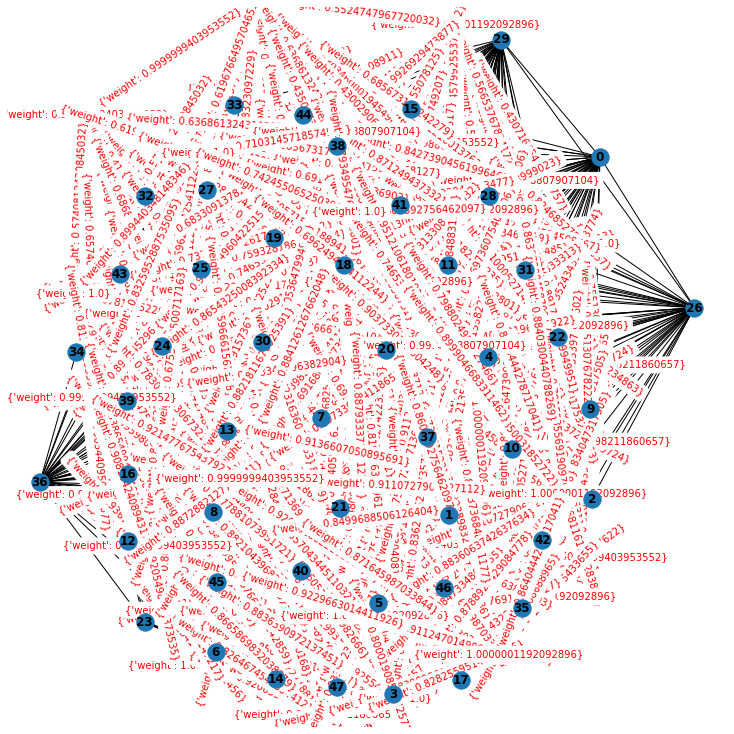

In [ ]:
draw_graphs(data['simMatrix'][0])

In [ ]:
#그래프를 알고리즘의 입력으로 사용하여 각 문장의 점수를 구하고 score이라는 열 생성
def calculate_score(sim_matrix):
  nx_graph=nx.from_numpy_array(sim_matrix)
  scores=nx.pagerank(nx_graph)
  return scores

In [ ]:
data['Score']=data['simMatrix'].apply(calculate_score)
data[['simMatrix', 'Score']]

,simMatrix,Score
0,"[[1.0000001192092896, 0.5249062776565552, 0.43...","{0: 0.014714135760504485, 1: 0.021520243179548..."
1,"[[0.9999999403953552, 0.8738642930984497, 0.90...","{0: 0.03260749927904618, 1: 0.0313335803120259..."
2,"[[1.0000001192092896, 0.9037330150604248, 0.53...","{0: 0.01141132674528322, 1: 0.0102782356320214..."
3,"[[0.9999999403953552, 0.5801534652709961, 0.67...","{0: 0.024098974270664243, 1: 0.021772703945943..."
4,"[[1.0000001192092896, 0.8693801164627075, 0.83...","{0: 0.04051588815235644, 1: 0.0394375885263637..."
...,...,...
95,"[[1.0000001192092896, 0.40615421533584595, 0.4...","{0: 0.011657606945812771, 1: 0.014580846554615..."
96,"[[1.0000001192092896, 0.749415934085846, 0.747...","{0: 0.005539590955949056, 1: 0.006282769721291..."
97,"[[1.0000001192092896, 0.7702449560165405, 0.68...","{0: 0.01721749712495556, 1: 0.0158273868546690..."
98,"[[1.0000001192092896, 0.7257768511772156, 0.75...","{0: 0.01118410570830755, 1: 0.0139329979895408..."


In [ ]:
len(data['Score'][0])

48

In [ ]:
data['Score'][0]

{0: 0.014714135760504485,
 1: 0.021520243179548135,
 2: 0.021585261459417325,
 3: 0.02202794352746301,
 4: 0.0202038446936251,
 5: 0.02154436174662755,
 6: 0.021450722446941434,
 7: 0.021992832978586677,
 8: 0.021009554351263535,
 9: 0.021023654758115747,
 10: 0.022126306899592205,
 11: 0.021006121564720627,
 12: 0.021520243179548135,
 13: 0.021463885817522278,
 14: 0.02164648881861331,
 15: 0.020109596190898523,
 16: 0.020746727857436222,
 17: 0.020532172707467714,
 18: 0.0202038446936251,
 19: 0.021070941381295595,
 20: 0.021891087085117486,
 21: 0.02154436174662755,
 22: 0.021936219634213393,
 23: 0.021157557943942987,
 24: 0.02153036484541227,
 25: 0.02170550904712733,
 26: 0.014300144195002461,
 27: 0.021542535770796154,
 28: 0.02190770333414252,
 29: 0.014300144195002461,
 30: 0.022023879397261192,
 31: 0.021609715051996044,
 32: 0.02100612156472062,
 33: 0.01915813952001548,
 34: 0.02135555301366805,
 35: 0.021783436639244275,
 36: 0.018133917924335538,
 37: 0.021507022552331015

In [ ]:
#점수가 가장 높은 문장들을 상위 n개 선택하여 이 문서의 요약문으로 함. 
def ranked_sentences(sentences, scores, n=3):
  top_scores=sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
  top_n_sentences=[sentence for score, sentence in top_scores[:n]]
  return " ".join(top_n_sentences)

In [ ]:
data['summary2']=data.apply(lambda x:ranked_sentences(x.tokenize_Text, x.Score), axis=1)

In [ ]:
for i in range(0, len(data)):
  print(i+1, '번')
  print('원문 : ', data.loc[i].Text)
  print('요약 : ', data.loc[i].summary2)
  print('데이터자체요약 : ', data.loc[i].Summary)
  print('')

1 번
원문 :  I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
요약 :  appreciates products several
데이터자체요약 :  Good Quality Dog Food

2 번
원문 :  Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
요약 :  unsalted salted peanuts
데이터자체요약 :  Not as Advertised

3 번
원문 :  This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, 